In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
df = pd.read_csv('/kaggle/input/email-spam-classification-dataset/combined_data.csv')

print("Columns:", df.columns)
print("Sample data:\n", df.head())

def clean_text(text):
    text = re.sub(r"http\S+", "", str(text))     
    text = re.sub(r"[^a-zA-Z\s]", "", text)        
    text = text.lower().strip()
    return text

df['text'] = df['text'].apply(clean_text)

Columns: Index(['label', 'text'], dtype='object')
Sample data:
    label                                               text
0      1  ounce feather bowl hummingbird opec moment ala...
1      1  wulvob get your medircations online qnb ikud v...
2      0   computer connection from cnn com wednesday es...
3      1  university degree obtain a prosperous future m...
4      0  thanks for all your answers guys i know i shou...


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['text']).toarray()
y = df['label'].values  

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)

In [4]:

joblib.dump(vectorizer, 'vectorizer.pkl')
print(" Vectorizer saved as vectorizer.pkl")

 Vectorizer saved as vectorizer.pkl


In [5]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")

Train samples: 66758, Test samples: 16690


In [6]:
class SpamClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(SpamClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x):
        return self.model(x)

model = SpamClassifier(input_size=X.shape[1])

In [7]:
print(X.shape[1])

1000


In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
num_epochs = 20
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)

        loss = criterion(outputs, labels.unsqueeze(1).float())

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")


Epoch [1/20] - Loss: 0.1178
Epoch [2/20] - Loss: 0.0704
Epoch [3/20] - Loss: 0.0537
Epoch [4/20] - Loss: 0.0417
Epoch [5/20] - Loss: 0.0332
Epoch [6/20] - Loss: 0.0261
Epoch [7/20] - Loss: 0.0204
Epoch [8/20] - Loss: 0.0158
Epoch [9/20] - Loss: 0.0127
Epoch [10/20] - Loss: 0.0106
Epoch [11/20] - Loss: 0.0086
Epoch [12/20] - Loss: 0.0076
Epoch [13/20] - Loss: 0.0064
Epoch [14/20] - Loss: 0.0057
Epoch [15/20] - Loss: 0.0049
Epoch [16/20] - Loss: 0.0056
Epoch [17/20] - Loss: 0.0053
Epoch [18/20] - Loss: 0.0046
Epoch [19/20] - Loss: 0.0042
Epoch [20/20] - Loss: 0.0045


In [10]:
model.eval()
train_preds, train_labels = [], []

with torch.no_grad():
    for features, labels in train_loader:
        outputs = model(features)
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).int().squeeze(1)
        train_preds.extend(predicted.numpy())
        train_labels.extend(labels.numpy())

# Compute training accuracy
train_accuracy = np.mean(np.array(train_preds) == np.array(train_labels))
print(f"\n Training Accuracy: {train_accuracy * 100:.2f}%")



 Training Accuracy: 99.68%


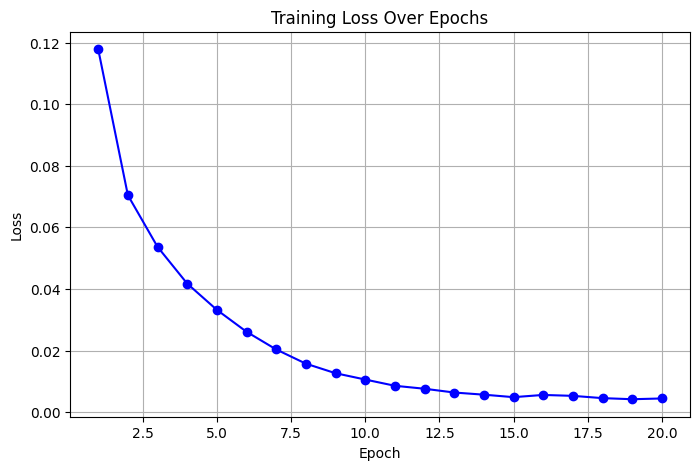

In [11]:
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [12]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).int().squeeze(1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\n Test Accuracy: {accuracy*100:.2f}%")



 Test Accuracy: 97.91%


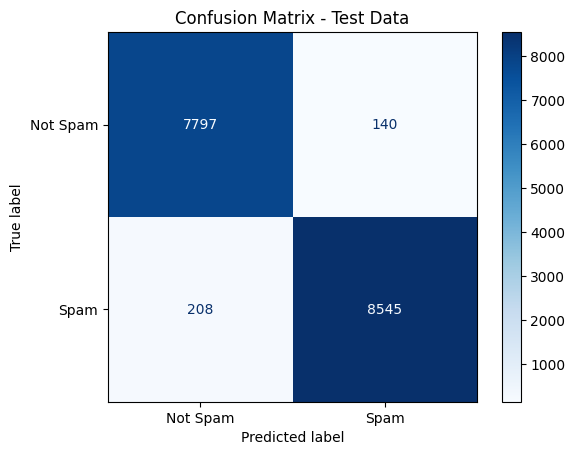


 Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.97      0.98      0.98      7937
        Spam       0.98      0.98      0.98      8753

    accuracy                           0.98     16690
   macro avg       0.98      0.98      0.98     16690
weighted avg       0.98      0.98      0.98     16690



In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Spam", "Spam"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Test Data")
plt.show()

print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Not Spam", "Spam"]))


In [14]:
torch.save(model.state_dict(), "email_spam_classifier.pth")